In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
from scipy.stats import gaussian_kde
from numpy.random import default_rng
import protfasta
from scipy.stats import mannwhitneyu

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
import random

# About
Update for revisions

In [5]:
# --------------------------------------------------------
#
def seq_match(reference, query):
    """
    Function that returns positions where reference and query 
    sequence do not match.
    
    Parameters
    ---------------
    reference : str
        Amino acid string of reference sequence
        
    query : str
        Amino acid sequence of non-reference sequence.
        
    Returns
    -----------
    list 
        Returns a list where each position defines the 
        0-indexed location where two sequences do not 
        match.
    """
    
    mismatches = []
    
    for r in range(len(reference)):
        if reference[r] != query[r]:
            mismatches.append(r)
            
    return mismatches

# --------------------------------------------------------
#
def wt_match(reference, query):
    """
    Function that returns a binary vector where 1
    indicates a match between reference and query
    sequence and 0 indicates a mismatch.        

    Parameters
    ---------------
    reference : str
        Amino acid string of reference sequence

    query : str
        Amino acid sequence of non-reference sequence.

    Returns
    -----------
    list 
        Returns a binary list where each position defines the 
        match (1) or mismatch (0) between two sequences.    

    """    
    match_vector = []
    
    for r in range(len(reference)):
        if reference[r] != query[r]:
            match_vector.append(0)
        else:
            match_vector.append(1)
            
    return match_vector


### Read in data
Read in the sequences with protfasta (installable via `pip install protfasta`) and then remove the wildtype sequence from the set of viable sequences.

In [3]:
viable = protfasta.read_fasta('error_prone_pcr_sequences/ncs_viable.fasta')
inviable  = protfasta.read_fasta('error_prone_pcr_sequences/ncs_inviable.fasta')
WT = viable.pop('WT', None)
print(f"Found {len(viable)} viable sequences and {len(inviable)} inviable sequences.")

Found 13 viable sequences and 35 inviable sequences.


Count number of mutations in viable and inviable datasets

In [6]:
viable_count = {}
inviable_count = {}

for j in viable:
    viable_count[j] = len(seq_match(WT, viable[j]))

for j in inviable:
    inviable_count[j] = len(seq_match(WT, inviable[j]))



In [10]:
print(f"Average number of mutations in viable sequences: {np.mean(list(viable_count.values())):.2f} +/- {np.std(list(viable_count.values())):.2f}")
print(f"Average number of mutations in inviable sequences: {np.mean(list(inviable_count.values())):.2f} +/- {np.std(list(inviable_count.values())):.2f}")


Average number of mutations in viable sequences: 28.00 +/- 17.85
Average number of mutations in inviable sequences: 45.29 +/- 13.46


In [11]:
print(f'Minimum mutations in viable set: {np.min([viable_count[i] for i in viable_count])}')
print(f'Max mutations in viable set: {np.max([viable_count[i] for i in viable_count])}')
print('')
print(f'Minimum mutations in inviable set: {np.min([inviable_count[i] for i in inviable_count])}')
print(f'Max mutations in inviable set: {np.max([inviable_count[i] for i in inviable_count])}')

Minimum mutations in viable set: 5
Max mutations in viable set: 56

Minimum mutations in inviable set: 21
Max mutations in inviable set: 76


In [12]:
print(f'There are {len(viable_count)} viable variants')
print(f'There are {len(inviable_count)} inviable variants')

There are 13 viable variants
There are 35 inviable variants


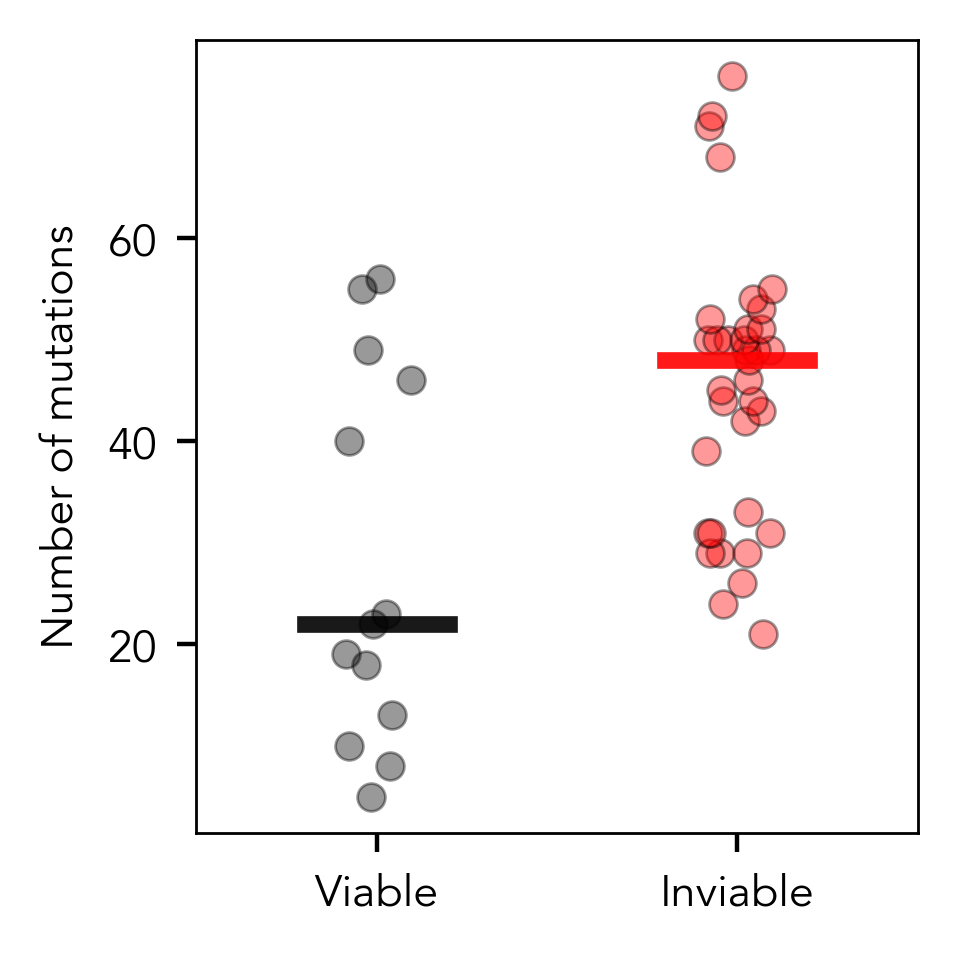

In [24]:
figure(num=None, figsize=(2.5, 2.5), dpi=200, facecolor='w', edgecolor='k')

# define random jitter 
jitter = np.random.uniform(size=len(viable))*0.2-0.10
plt.plot(jitter+1, np.array(list(viable_count.values())),'o',alpha=0.4, ms=5, color='black', markeredgecolor='k',mew=0.5)

jitter = np.random.uniform(size=len(inviable))*0.2-0.1
plt.plot(jitter+2, np.array(list(inviable_count.values())),'o',alpha=0.4, ms=5, color='red', markeredgecolor='k', mew=0.5)

median_viable = np.median(list(viable_count.values()))
median_inviable = np.median(list(inviable_count.values()))

plt.plot([1-0.2,1+0.2], [median_viable, median_viable],'-k', linewidth=3, alpha=0.9)

plt.plot([2-0.2, 2+0.2], [median_inviable, median_inviable],'-r', linewidth=3, alpha=0.9)

plt.xlim([0.5, 2.5])
plt.yticks([20,40,60], fontsize=8)
plt.ylabel(r'Number of mutations', fontsize=8)
plt.xticks([1,2],['Viable','Inviable'], fontsize=8)
plt.tight_layout()
plt.savefig('figures/error_prone_pcr_viable_vs_mutant_count.pdf')





In [14]:
viable_c = list(viable_count.values())
inviable_c = list(inviable_count.values())


In [15]:

bootstrap_runs=5000
sample_sizes = list(range(5,len(viable_c)+1))
sample_size_mean_pvals = []
sample_size_std_pvals = []

for sample_size in sample_sizes:

    p_vals = []
    for i in range(bootstrap_runs):
        random.shuffle(viable_c)
        random.shuffle(inviable_c)
        s1 = viable_c[0:sample_size]
        s2 = inviable_c[0:sample_size]
    
        p_vals.append(mannwhitneyu(s1, s2)[1])
        
    sample_size_mean_pvals.append(np.mean(p_vals))
    sample_size_std_pvals.append(np.std(p_vals))
        
    
    

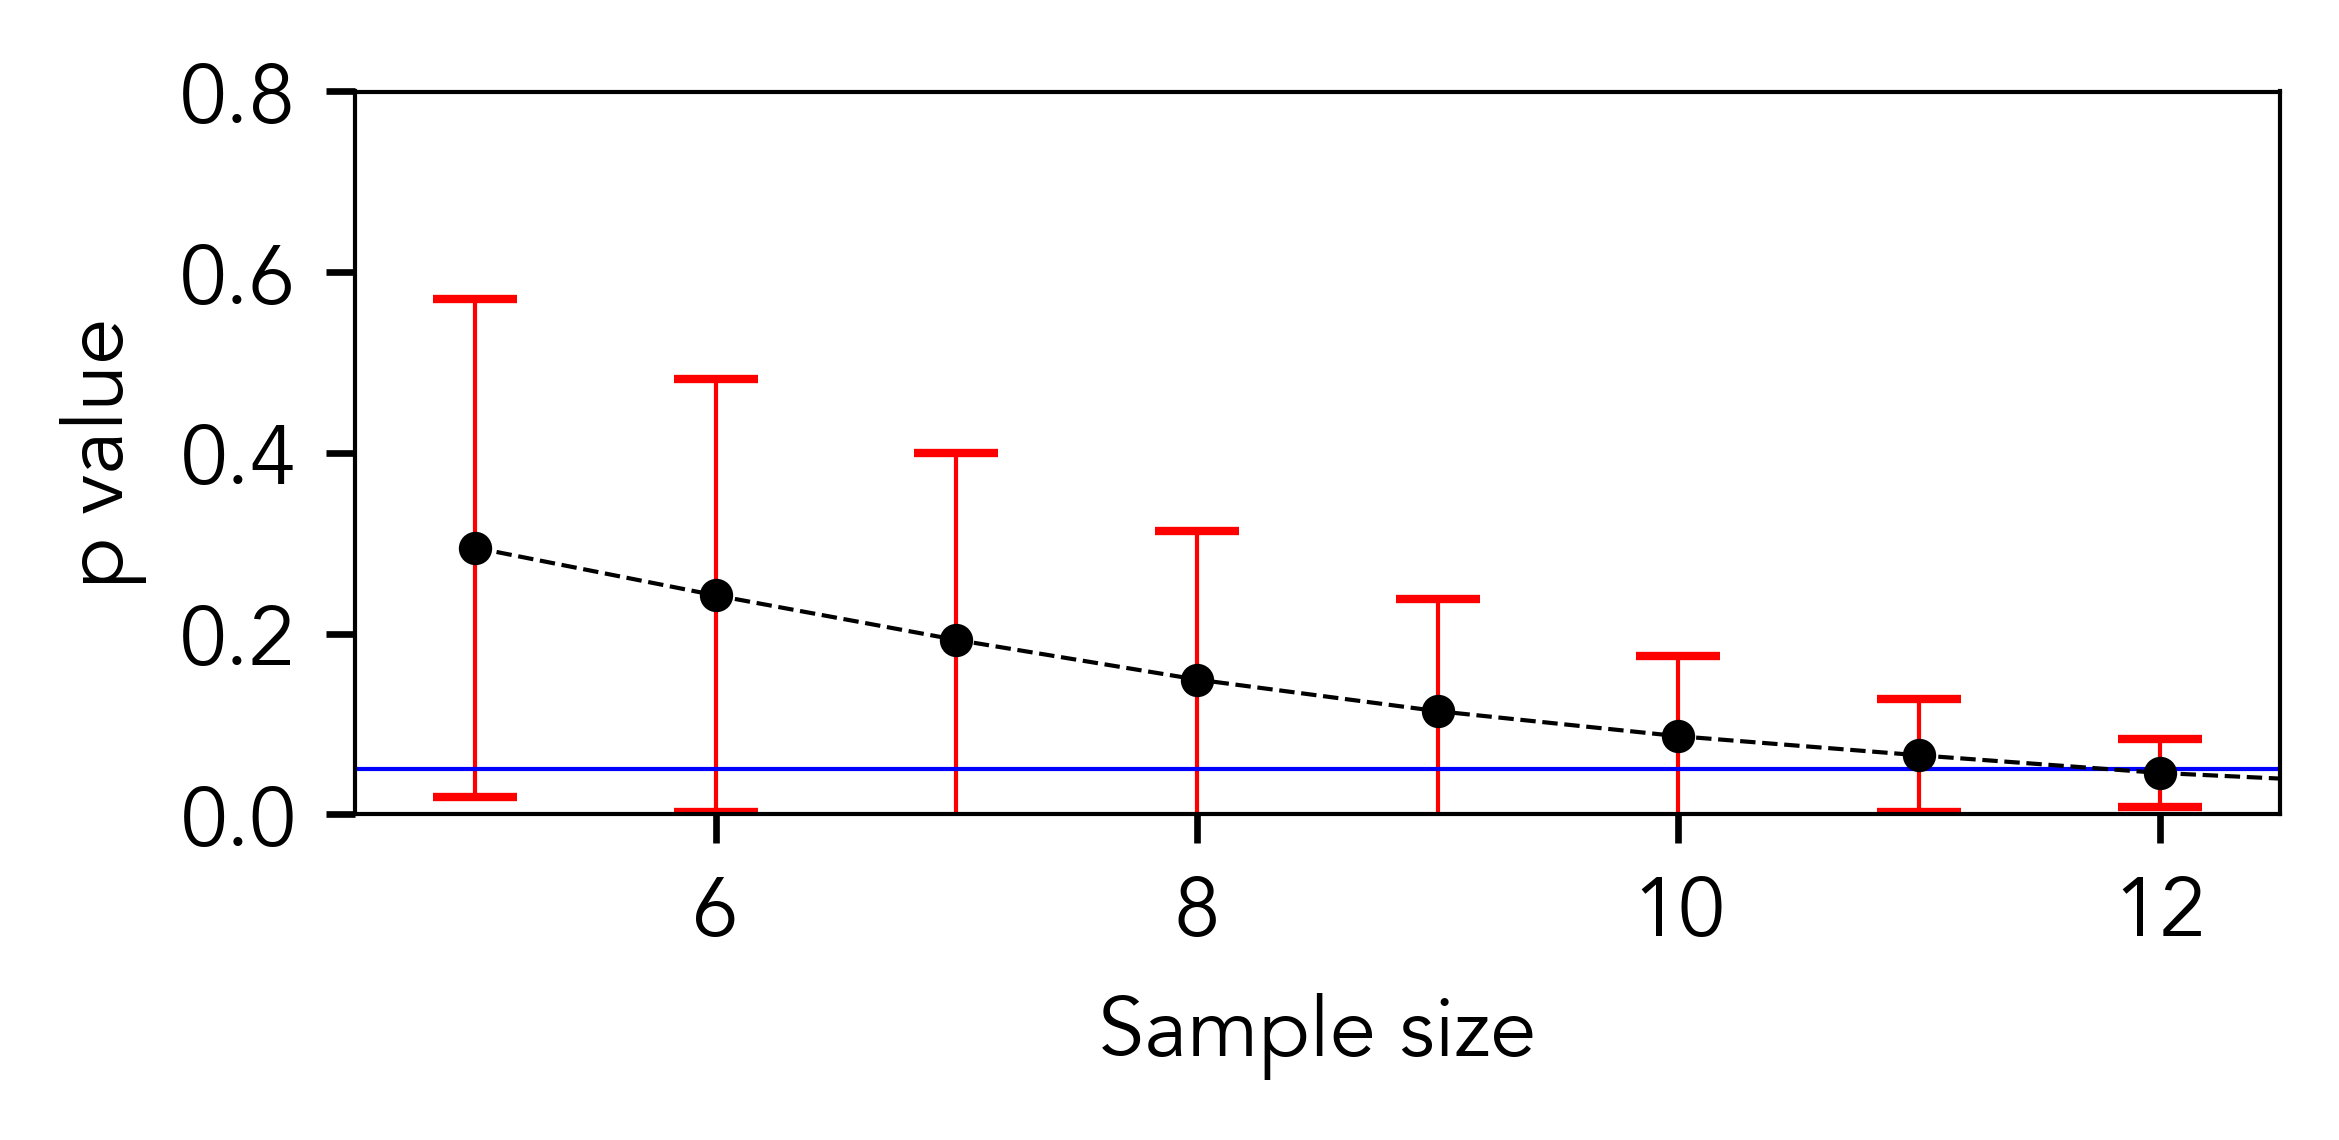

In [16]:
figure(num=None, figsize=(4, 2), dpi=300, facecolor='w', edgecolor='k')
plt.errorbar(sample_sizes, sample_size_mean_pvals, sample_size_std_pvals, 
             fmt='o--k', ms=3, ecolor='r', lw=0.5,
             capsize=5)
plt.plot([4,13],[0.05,0.05],'-b', linewidth=0.5)
plt.ylabel('p value')
plt.xlabel('Sample size')
plt.ylim([0,0.8])
plt.xlim([4.5,12.5])
plt.tight_layout()
plt.savefig('figures/error_prone_pcr_p_value_random_mutagenesis.pdf')
         
    

In [17]:
# note now we have very different sample sizes in limit of one dataset having a small sample size. 
# Statistically ropey...
print('Mann Whitney U p Value = %1.3f'%(mannwhitneyu(np.array(list(inviable_count.values())), np.array(list(viable_count.values())))[1]))




Mann Whitney U p Value = 0.007


In [18]:
inviable_count = dict(sorted(inviable_count.items(), key=lambda item: item[1]))
viable_count = dict(sorted(viable_count.items(), key=lambda item: item[1]))

all_vectors = []
for i in viable_count:
    all_vectors.append(wt_match(WT, viable[i]))
    
all_vectors.append([0]*len(WT))
    
for i in inviable_count:
    all_vectors.append(wt_match(WT, inviable[i]))


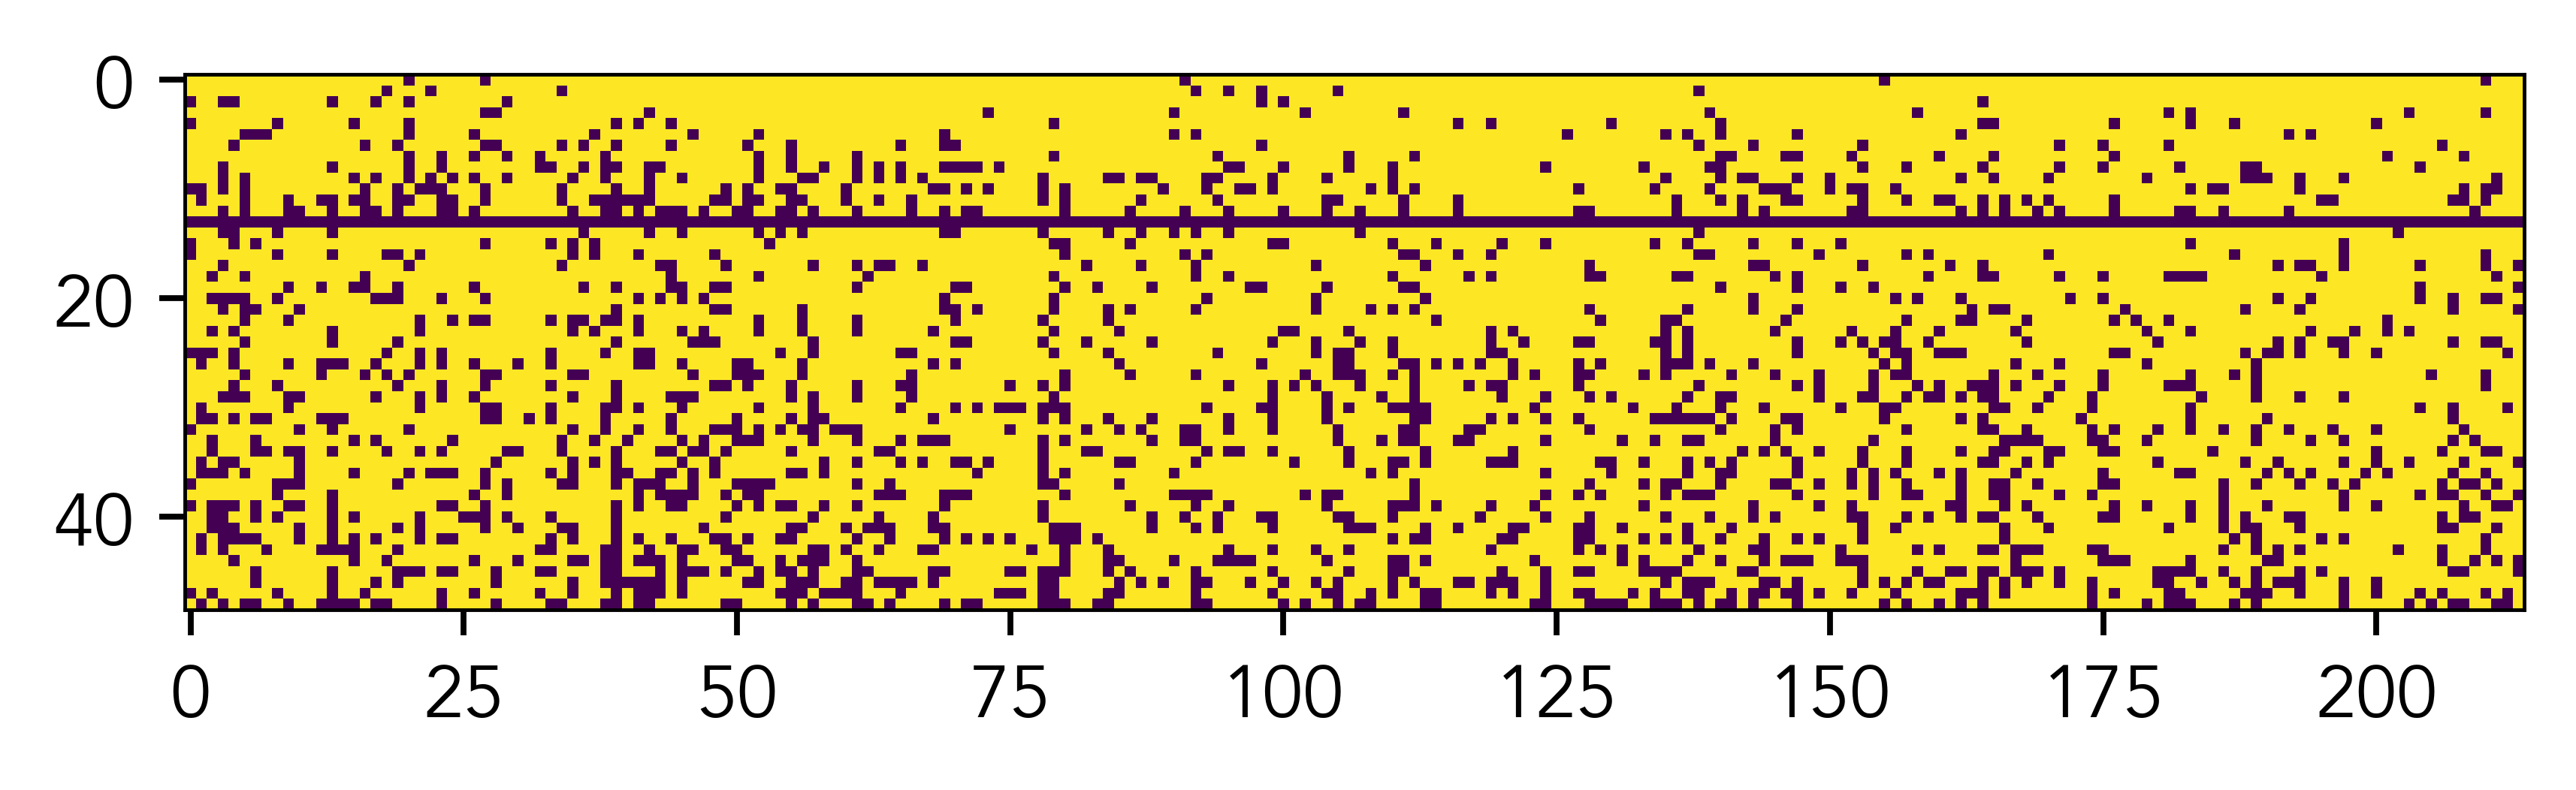

In [21]:

figure(num=None, figsize=(5, 3), dpi=350, facecolor='w', edgecolor='k')

plt.imshow(np.array(all_vectors))
plt.tight_layout()
plt.savefig('figures/error_prone_pcr_raw_mutation_matrix.pdf')